In [127]:
import pandas as pd
import networkx as nx
import itertools
import matplotlib.pyplot as plt
import random
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, precision_recall_curve, average_precision_score, auc
import json
from networkx.algorithms import bipartite

In [128]:
# Get cluster information
# Read the JSON string from the .txt file
with open('cluster_dictionaries.txt', 'r') as file:
    json_data = file.read()

# Convert the JSON string back to a dictionary
cluster_dictionaries = json.loads(json_data)

# Extract individual dictionaries
cluster_dict_all_descriptor = cluster_dictionaries['cluster_dict_all_descriptor']
cluster_dict_nbo_descriptor = cluster_dictionaries['cluster_dict_nbo_descriptor']
cluster_dict_vbur_descriptor = cluster_dictionaries['cluster_dict_vbur_descriptor']

# Print the dictionaries to verify
print("cluster_dict_all_descriptor:", cluster_dict_all_descriptor)
print("cluster_dict_nbo_descriptor:", cluster_dict_nbo_descriptor)
print("cluster_dict_vbur_descriptor:", cluster_dict_vbur_descriptor)

# Extract a list of 'd_nodes that are from dft calculations
dft_ligand_ids = []

# Iterate through the dictionary and collect all ligand_ids
for cluster, ligand_ids in cluster_dict_all_descriptor.items():
    dft_ligand_ids.extend(ligand_ids)

# Print the amount of all ligand_ids
num_dft_ligand_ids = len(dft_ligand_ids)
print(num_dft_ligand_ids)

cluster_dict_all_descriptor: {'c1': ['038', '072', '073', '074', '075', '076', '077', '078', '092', '099', '111', '121', '122', '145', '146', '149', '150', '151', '160', '161', '168', '169', '170', '171', '172', '173', '174', '177', '178', '179', '180', '181', '182', '183', '186', '199', '200', '201', '202', '205', '207', '208', '209', '210', '211', '212', '213', '214', '215', '216', '217', '218', '219', '220', '221', '222', '223', '224', '225', '226', '227', '228', '229', '230', '231', '237', '238', '239', '240', '241', '250', '251', '252', '254', '257', '259', '264', '265', '296', '299', '301', '303', '309', '310', '311', '312', '348', '350', '353', '356', '357', '358', '359', '360', '387'], 'c2': ['022', '031', '040', '042', '053', '056', '057', '058', '084', '085', '086', '087', '089', '090', '096', '098', '114', '117', '118', '123', '129', '132', '134', '136', '162', '163', '164', '165', '166', '167', '190', '244', '255', '269', '270', '275', '276', '280', '287', '304', '305', '30

In [129]:
# File name of the Excel document containing the ligand dataset
file_name = 'master_ligand_dataset.csv'

# Read the Excel file
df = pd.read_csv(file_name)

In [130]:
df

lig_id ligand_name  exp_id                                  ref  \
0          1       n-n-1       1    ChemSusChem, 2011, 4, 1275 – 1279   
1          1       n-n-1       2    ChemSusChem, 2011, 4, 1275 – 1279   
2          2       p-p-1       3    ChemSusChem, 2011, 4, 1275 – 1279   
3          2       p-p-1       4    ChemSusChem, 2011, 4, 1275 – 1279   
4          3       p-p-2       5    ChemSusChem, 2011, 4, 1275 – 1279   
...      ...         ...     ...                                  ...   
1943     410      p-p-29    1944  Organometallics 2018, 37, 3573−3580   
1944     410      p-p-29    1945  Organometallics 2018, 37, 3573−3580   
1945      36      p-p-15    1946  Organometallics 2018, 37, 3573−3580   
1946     410      p-p-29    1947  Organometallics 2018, 37, 3573−3580   
1947      36      p-p-15    1948  Organometallics 2018, 37, 3573−3580   

     substrate_comb metal substrate_1 substrate_2 solvent  temperature  ...  \
0       CO2Ethylene    Ni         CO2    ethylene     dcm         25.0  ...   
1       CO2Ethylene    Ni         CO2    ethylene     dcm         25.0  ...   
2       CO2Ethylene    Ni         CO2    ethylene     dcm         25.0  ...   
3       CO2Ethylene    Ni         CO2    ethylene     dcm         25.0  ...   
4       CO2Ethylene    Ni         CO2    ethylene     dcm         25.0  ...   
...             ...   ...         ...         ...     ...          ...  ...   
1943            NaN    Ni         CO2    ethylene     THF        110.0  ...   
1944            NaN    Ni         CO2    ethylene     THF        110.0  ...   
1945            NaN    Ni         CO2    ethylene     THF        110.0  ...   
1946            NaN    Ni         CO2    ethylene     THF        110.0  ...   
1947            NaN    Ni         CO2    ethylene     THF        110.0  ...   

      additive additive_equiv substrate_ratio  volume_ml activity_kg_mol  \
0         ch3i             10             NaN        4.0             NaN   
1         ch3i            100             NaN        4.0             NaN   
2         ch3i             10             NaN        4.0             NaN   
3         ch3i            100             NaN        4.0             NaN   
4         ch3i             10             NaN        4.0             NaN   
...        ...            ...             ...        ...             ...   
1943        Zn            NaN             NaN       25.0             NaN   
1944       NaN            NaN             NaN       25.0             NaN   
1945        Zn            NaN             NaN       25.0             NaN   
1946    NaI,Zn            NaN             NaN       25.0             NaN   
1947    NaI,Zn            NaN             NaN       25.0             NaN   

     yield   mn  time_hr  incorporatio_ratio    ton  
0     21.0  NaN      3.0                 NaN    NaN  
1     56.0  NaN      3.0                 NaN    NaN  
2     14.0  NaN     48.0                 NaN    NaN  
3     29.0  NaN     48.0                 NaN    NaN  
4     18.0  NaN     24.0                 NaN    NaN  
...    ...  ...      ...                 ...    ...  
1943   NaN  NaN     20.0                 NaN   30.0  
1944   NaN  NaN     20.0                 NaN   21.0  
1945   NaN  NaN     20.0                 NaN  135.0  
1946   NaN  NaN     20.0                 NaN   30.0  
1947   NaN  NaN     20.0                 NaN  404.0  

[1948 rows x 24 columns]

In [131]:
# Filter the DataFrame for rows where substrate_1 is 'CO2'
filtered_df = df[df['substrate_1'] == 'CO2']

# Get unique lig_id values
unique_lig_ids = filtered_df['lig_id'].unique()

# Convert to list (if needed)
unique_lig_ids_list = unique_lig_ids.tolist()

print(unique_lig_ids_list)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 71, 72, 14, 15, 16, 17, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 64, 65, 66, 67, 68, 69, 70, 44, 410]


In [132]:
columns_of_interest = ['ligand_name','lig_id','substrate_1','substrate_2']
lig_rxn_df = df[columns_of_interest]
# Convert 'lig_id' to string with leading zeros
lig_rxn_df['lig_id'] = lig_rxn_df['lig_id'].apply(lambda x: f"{x:03}")

# Identify rows to remove from lig_rxn_df
removed_ligand_ids = lig_rxn_df.loc[~lig_rxn_df['lig_id'].isin(dft_ligand_ids), 'lig_id'].tolist()
print("Experimental Ligand ids not calculated:", set(removed_ligand_ids))

# If lig_id from this experimental dataframe isn't in the dft_lig_id list, please remove row
lig_rxn_df = lig_rxn_df[lig_rxn_df['lig_id'].isin(dft_ligand_ids)]

unique_lig_ids_df = set(lig_rxn_df['lig_id'].unique())
print('Updated number for number of experimental ligand ids', len(unique_lig_ids_df))
unique_dft_ligand_ids = set(dft_ligand_ids)
# assert len(unique_lig_ids_df) == len(unique_dft_ligand_ids), f"Mismatch in unique lig_id counts: ligand-id has {len(unique_lig_ids_df)}, DFT-ligand_list has {len(unique_dft_ligand_ids)}"


# Update the cluster dictionaries by keeping only those ligand_ids present in unique_lig_ids_set
updated_cluster_dict_all_descriptor = {
    cluster: [lig_id for lig_id in ligand_ids if lig_id in unique_lig_ids_df]
    for cluster, ligand_ids in cluster_dict_all_descriptor.items()
}

updated_cluster_dict_vbur_descriptor = {
    cluster: [lig_id for lig_id in ligand_ids if lig_id in unique_lig_ids_df]
    for cluster, ligand_ids in cluster_dict_vbur_descriptor.items()
}

updated_cluster_dict_nbo_descriptor = {
    cluster: [lig_id for lig_id in ligand_ids if lig_id in unique_lig_ids_df]
    for cluster, ligand_ids in cluster_dict_nbo_descriptor.items()
}

# Re-extract a list of 'd_nodes' that are from dft calculations
updated_dft_ligand_ids = []

# Iterate through the dictionary and collect all ligand_ids
for cluster, ligand_ids in updated_cluster_dict_all_descriptor.items():
    updated_dft_ligand_ids.extend(ligand_ids)

# Print the amount of all ligand_ids
updated_num_dft_ligand_ids = len(updated_dft_ligand_ids)
print('Updated number for number of dft ligand ids', updated_num_dft_ligand_ids)

# Compare updated and original dft list of ligand ids, show me a list of ids that are not in both:
updated_unique_dft_ligand_ids = set(updated_dft_ligand_ids)
difference = list(updated_unique_dft_ligand_ids.symmetric_difference(unique_dft_ligand_ids))
# Print the result
print("DFT ligand ids not included in updated lists:", difference)


lig_rxn_df = lig_rxn_df.drop_duplicates()
lig_rxn_df

Experimental Ligand ids not calculated: {'015', '024', '062', '012', '034', '051', '451', '067', '017', '065', '001', '185', '016', '052', '014', '455', '050', '454', '023', '054', '028', '066', '026', '064', '061', '049', '025', '069', '235', '068', '453', '063', '410', '070', '452'}
Updated number for number of experimental ligand ids 367
Updated number for number of dft ligand ids 367
DFT ligand ids not included in updated lists: ['215', '040', '333', '334', '264', '037', nan, '265', '411']


C:\Users\George\AppData\Local\Temp\ipykernel_33520\414108509.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lig_rxn_df['lig_id'] = lig_rxn_df['lig_id'].apply(lambda x: f"{x:03}")


ligand_name lig_id substrate_1                substrate_2
2          p-p-1    002         CO2                   ethylene
4          p-p-2    003         CO2                   ethylene
6          p-p-3    004         CO2                   ethylene
8          c-n-1    005         CO2                   ethylene
9          c-n-2    006         CO2                   ethylene
...          ...    ...         ...                        ...
1925      n-n-81    403    ethylene  5-norbornene-2-yl acetate
1926      n-n-27    309    ethylene  5-norbornene-2-yl acetate
1927      p-n-31    404    ethylene                       none
1928      p-n-32    405    ethylene                       none
1929      p-n-33    406    ethylene                       none

[798 rows x 4 columns]

In [133]:
# Extract combination of donor atoms
lig_rxn_df['donor_atoms'] = lig_rxn_df['ligand_name'].str.extract(r'([a-z]-[a-z])')
# lig_rxn_df.loc[:,'donor_atoms'] = lig_rxn_df['ligand_name'].str.extract(r'([a-z]-[a-z])')

# Create new reaction class based on substrate_1 and substrate_2
lig_rxn_df['reaction_class'] = lig_rxn_df.apply(lambda row: '-'.join(sorted([row['substrate_1'], row['substrate_2']])), axis=1)
print(lig_rxn_df.sample(n=20, random_state=42))

# Identify number of ligands for each donor atom class


     ligand_name lig_id substrate_1                             substrate_2  \
1687      n-n-55    358    ethylene                                    none   
1639      n-n-49    344    ethylene                         methyl acrylate   
158        p-o-9    083    ethylene                                    DMAA   
1344     p-o-117    305    ethylene  5-norbonene-2,3-dicarboxylic anhydride   
163       p-o-11    085    ethylene                                    none   
1560      n-n-47    339    ethylene                         methyl acrylate   
953       n-o-79    242   norbonene                           CH2CH(CH2)4OH   
1221      p-o-92    284    ethylene                                    none   
1603     p-o-139    408    ethylene                         CH2CH(CH2)8COOH   
1135      p-o-82    273    ethylene                                    none   
162        p-o-5    041    ethylene                                    none   
798       n-o-46    205    ethylene                 

In [134]:
# Analyze dataframe, obtain statistics
# Identify ligands that have been used in multiple reaction types
# Group by 'ligand_name' and aggregate the reaction_class into a list
reaction_classes = lig_rxn_df.groupby('ligand_name')['reaction_class'].agg(lambda x: list(set(x))).reset_index()

# Rename the aggregated column to 'reaction_classes'
reaction_classes.rename(columns={'reaction_class': 'reaction_classes'}, inplace=True)

# Enter ligand_name, obtain reaction classes that uses the particular ligand
ligand_name = 'n-n-46'
result = reaction_classes.loc[reaction_classes['ligand_name'] == ligand_name, 'reaction_classes']
print(result)

57    [ethylene-none, ethylene-methyl acrylate]
Name: reaction_classes, dtype: object


In [135]:
# Identify number and name of unique ligands used for each reaction type
# Group by 'reaction_class' and count unique 'ligand_name'
reaction_class_counts = lig_rxn_df.groupby('reaction_class')['ligand_name'].nunique().reset_index()

# Rename the column to reflect the count of unique ligands
reaction_class_counts.rename(columns={'ligand_name': 'unique_ligand_count'}, inplace=True)

print(reaction_class_counts)

# Group by 'reaction_class' and aggregate unique 'ligand_name' into lists
reaction_class_ligands = lig_rxn_df.groupby('reaction_class')['ligand_name'].agg(lambda x: list(set(x))).reset_index()

# Rename the column to reflect the list of unique ligands
reaction_class_ligands.rename(columns={'ligand_name': 'unique_ligands'}, inplace=True)

# Display the result
print(reaction_class_ligands)

                                       reaction_class  unique_ligand_count
0   (E)-1,3-diphenylprop-3-en-1-yl acetate-dimethy...                    5
1                                       1-butene-none                    2
2                                   1-hexene-ethylene                    3
3                               2-vinylfuran-ethylene                    6
4                              4-penten-1-ol-ethylene                    1
..                                                ...                  ...
72                          methyl acrylate-norbonene                    5
73                          methyl acrylate-propylene                    3
74                                     none-norbonene                   10
75                                     none-propylene                   13
76                                  norbonene-styrene                    3

[77 rows x 2 columns]
                                       reaction_class  \
0   (E)-1,3-diphenyl

In [136]:
# Identify donor atom classes types for each reaction types, and quantify how many ligands are there for each donor atom class? We can examine which donor atom 
# class is more popular in literature than others through this statistic.

# Group by 'reaction_class' and aggregate unique 'donor_atoms' into lists
reaction_class_donor_atoms = lig_rxn_df.groupby('reaction_class')['donor_atoms'].agg(lambda x: list(set(x))).reset_index()

# Rename the column to reflect the list of unique donor atoms
reaction_class_donor_atoms.rename(columns={'donor_atoms': 'unique_donor_atoms'}, inplace=True)

# Group by 'reaction_class' and 'donor_atoms', then aggregate unique 'ligand_names' into lists
reaction_class_donor_atoms_ligands = lig_rxn_df.groupby(['reaction_class', 'donor_atoms'])['ligand_name'].agg(lambda x: list(set(x))).reset_index()

# Add a column to count the number of unique 'ligand_names'
reaction_class_donor_atoms_ligands['unique_ligand_count'] = reaction_class_donor_atoms_ligands['ligand_name'].apply(len)

# Rename the column to reflect the list of unique ligands
reaction_class_donor_atoms_ligands.rename(columns={'ligand_name': 'unique_ligands'}, inplace=True)

# Display the results
print("List of unique donor_atoms used for each unique type of reaction_class:")
print(reaction_class_donor_atoms)

print("\nQuantification of unique ligand_names for each unique donor_atom within each type of reaction_class:")
print(reaction_class_donor_atoms_ligands)

List of unique donor_atoms used for each unique type of reaction_class:
                                       reaction_class unique_donor_atoms
0   (E)-1,3-diphenylprop-3-en-1-yl acetate-dimethy...              [p-c]
1                                       1-butene-none              [c-o]
2                                   1-hexene-ethylene              [p-o]
3                               2-vinylfuran-ethylene              [p-o]
4                              4-penten-1-ol-ethylene              [n-o]
..                                                ...                ...
72                          methyl acrylate-norbonene              [p-n]
73                          methyl acrylate-propylene         [c-o, p-o]
74                                     none-norbonene    [n-o, p-n, c-o]
75                                     none-propylene         [c-o, p-o]
76                                  norbonene-styrene              [n-o]

[77 rows x 2 columns]

Quantification of unique lig

In [137]:
# Create bipartite network between ligand_name and reaction types (use combinations of substrates)
# https://coderzcolumn.com/tutorials/data-science/network-analysis-in-python-important-structures-and-bipartite-graphs-networkx
# Use circos plot? 
# Objectives:
# Obtain dataset with two columns, one with ligand_id, one with ligand name, one with ligand class (donor atom combination) and one with reaction class
# Identify ligands that have been used in multiple reaction types
# Identify number of unique ligands used for each reaction type
# Identify number of ligands for each donor atom class
# Identify donor atom classes types for each reaction types, and quantify how many ligands are there for each donor atom class? We can examine which donor atom 
# class is more popular in literature than others through this statistic.


In [138]:
lig_rxn_df

ligand_name lig_id substrate_1                substrate_2 donor_atoms  \
2          p-p-1    002         CO2                   ethylene         p-p   
4          p-p-2    003         CO2                   ethylene         p-p   
6          p-p-3    004         CO2                   ethylene         p-p   
8          c-n-1    005         CO2                   ethylene         c-n   
9          c-n-2    006         CO2                   ethylene         c-n   
...          ...    ...         ...                        ...         ...   
1925      n-n-81    403    ethylene  5-norbornene-2-yl acetate         n-n   
1926      n-n-27    309    ethylene  5-norbornene-2-yl acetate         n-n   
1927      p-n-31    404    ethylene                       none         p-n   
1928      p-n-32    405    ethylene                       none         p-n   
1929      p-n-33    406    ethylene                       none         p-n   

                          reaction_class  
2                           CO2-ethylene  
4                           CO2-ethylene  
6                           CO2-ethylene  
8                           CO2-ethylene  
9                           CO2-ethylene  
...                                  ...  
1925  5-norbornene-2-yl acetate-ethylene  
1926  5-norbornene-2-yl acetate-ethylene  
1927                       ethylene-none  
1928                       ethylene-none  
1929                       ethylene-none  

[798 rows x 6 columns]

In [139]:
# Define functions here

def visualize_bipartite_graph(G, d_nodes, t_nodes):
    # pos = nx.bipartite_layout(G, nodes=d_nodes)
    # pos = {}
    # pos.update((node, (1, index)) for index, node in enumerate(d_nodes))  # positions for d nodes
    # pos.update((node, (2, index)) for index, node in enumerate(t_nodes))  # positions for t nodes

    #Spring layout
    pos = nx.spring_layout(G)

    # Define colors for the nodes
    node_colors = ['skyblue' if node in d_nodes else 'lightgreen' for node in G.nodes()]

    
    font_size = 8
    edge_width = 0.01
    # Draw nodes and edges
    plt.figure(figsize=(12, 8))
    nx.draw(G, pos, with_labels=True, node_color=node_colors,font_size=font_size,width=edge_width)
    plt.title("Bipartite Graph Visualization")

    # Save the figure
    plt.savefig('Bipartite Graph Visualization - Cross Validation.png')
    
    plt.show()

def preferential_attachment(G, d_node,t_node):
    d_degree = G.degree(d_node)
    t_degree = G.degree(t_node)

    pa = d_degree * t_degree
    return pa

def common_neighbor_jaccard_coef(G, d_node, t_node):
    # Get the neighbors of d_node and t_node
    d_neighbors = set(G.neighbors(d_node))
    t_neighbors = set(G.neighbors(t_node))

    # Get the extended neighbors of the d_neighbors and the t_neighbors
    d_neighbors_2 = set()
    for neighbor in d_neighbors:
        d_neighbors_2.update(G.neighbors(neighbor)) 
        
    t_neighbors_2 = set()
    for neighbor in t_neighbors:
        t_neighbors_2.update(G.neighbors(neighbor))
    
    # print("Second-degree neighbors from d_node:", d_neighbors_2)
    # print("Second-degree neighbors from t_node:", t_neighbors_2)
    
    # Find the common neighbors, using definition from New J Phys 17 (2015) 113037, where it's the number of nodes in the quadrangles between two seed nodes
    common_neighbors_d = d_neighbors_2 & t_neighbors
    # print('Common_neighbors_d:', common_neighbors_d)
    common_neighbor_count_d = len(common_neighbors_d)
    # print(common_neighbor_count_d)
    common_neighbors_t = t_neighbors_2 & d_neighbors
    # print('Common_neighbors_t:', common_neighbors_t)
    common_neighbor_count_t = len(common_neighbors_t)
    # print(common_neighbor_count_t)
    # Add up nodes from common_neighbors from d partite, and from t partite
    sum_common_neighbors_d_t = len(common_neighbors_d|common_neighbors_t)
    total_neighbors = len(d_neighbors|t_neighbors)
    # if total_neighbors == 0:
        # print('d_node with no neighbor?', d_node, 't_node with no neighbor?', t_node)
        # print('d_node_neighbor_check', d_neighbors, 't_node_neighbor_check', t_neighbors)
    # Calculate jaccard coefficient by deviding by the total amount of neighbors from d_node & t_node
    if total_neighbors != 0:
        jaccard_coefficient_d_t = sum_common_neighbors_d_t / total_neighbors
    else:
        jaccard_coefficient_d_t = 0
    # print('Total neighbors:', total_neighbors)
    # print('Jaccard_coefficient:', jaccard_coefficient_d_t)
    return sum_common_neighbors_d_t, jaccard_coefficient_d_t


# Function to calculate precision at top L and AUPR
def calculate_metric(df, score_type, l):
    # Sort the DataFrame based on the prediction score of the algorithm
    sorted_df = df.sort_values(by=score_type, ascending=False)
    
    # Calculate precision at top L
    top_L = sorted_df.head(l)
    precision_at_L = top_L['actual outcome'].sum() / l
    
    # Calculate AUPR
    precision, recall, _ = precision_recall_curve(sorted_df['actual outcome'], sorted_df[score_type])
    aupr = auc(recall, precision)
    
    return precision_at_L, aupr    

Length of ligand nodes:  367
Length of reaction class nodes:  77
Total number of possible edges: 28259
num_possible_edges 28259
Number of existing edges: 788
Number of possible edges: 28259
Number of missing edges: 27471


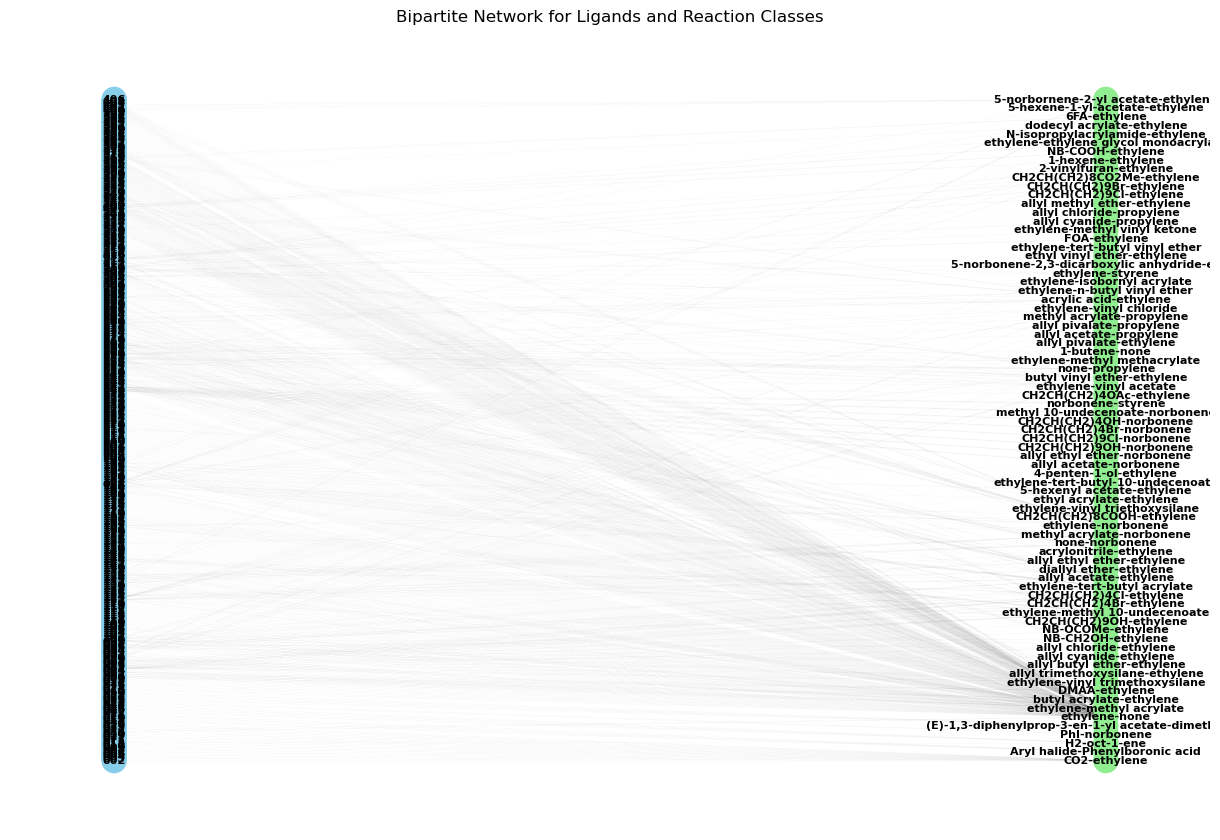

In [140]:
# Create bipartite network for visualization
# Set columns from pandas

lig_rxn_bipartite_df = lig_rxn_df[['lig_id','reaction_class']]

# Obtain unique list of ligand ids and reaction classes
d_nodes = lig_rxn_bipartite_df['lig_id'].unique()
t_nodes = lig_rxn_bipartite_df['reaction_class'].unique()

# Create a bipartite graph
exp_bipartite = nx.Graph()

# Add nodes from the first set (column1)
exp_bipartite.add_nodes_from(d_nodes, bipartite=0)

# Add nodes from the second set (column2)
exp_bipartite.add_nodes_from(t_nodes, bipartite=1)

# Add edges based on the DataFrame
edges = list(lig_rxn_bipartite_df.itertuples(index=False, name=None))
exp_bipartite.add_edges_from(edges)

# # Define edges connecting nodes from different sets
# edges = [(node1, node2) for node1 in d_nodes for node2 in t_nodes]
# # edges = [('A', 1), ('B', 2), ('C', 3)]
# exp_bipartite.add_edges_from(edges)

# Determine the number of nodes in each partite set
num_d_nodes, num_t_nodes = len(d_nodes), len(t_nodes)

print('Length of ligand nodes: ', num_d_nodes)
print('Length of reaction class nodes: ', num_t_nodes)

# Get total possible set of edges 
possible_edges = list(itertools.product(d_nodes, t_nodes))
# Print the total number of possible edges
print(f"Total number of possible edges: {len(possible_edges)}")

# Determine number of existing edges, missing edges
num_existing_edges = exp_bipartite.number_of_edges()
num_possible_edges = num_d_nodes*num_t_nodes
print('num_possible_edges', num_possible_edges)
# Number of missing edges
num_missing_edges = num_possible_edges - num_existing_edges

print('Number of existing edges:', num_existing_edges)
print('Number of possible edges:', num_possible_edges)
print('Number of missing edges:', num_missing_edges)

# Plot the bipartite graph
font_size = 8
edge_width = 0.01
pos = nx.bipartite_layout(exp_bipartite, nodes=d_nodes)

#Spring layout
# pos = nx.spring_layout(G


# Draw nodes and edges
plt.figure(figsize=(12, 8))

# Define colors for the nodes
node_colors = ['skyblue' if node in d_nodes else 'lightgreen' for node in exp_bipartite.nodes()]

nx.draw(exp_bipartite, pos, with_labels=True, font_weight='bold', node_color=node_colors,font_size=font_size,width=edge_width)

plt.title("Bipartite Network for Ligands and Reaction Classes")
plt.savefig('Bipartite network original dataset.png')

plt.show()



NetworkXError: Node '405' has no position.

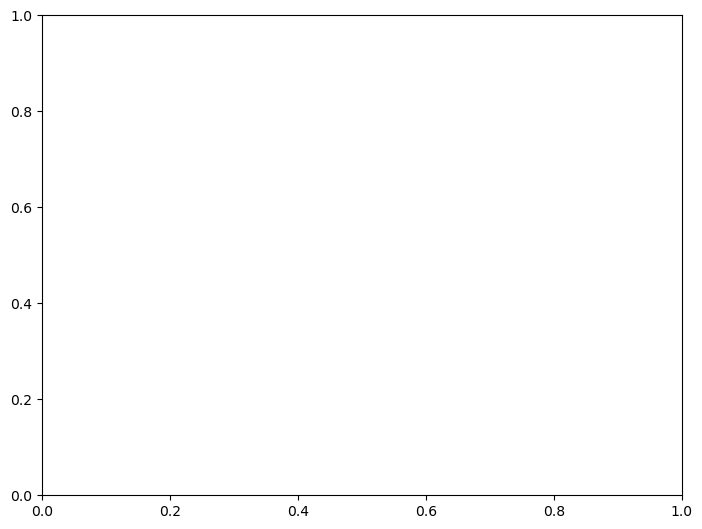

In [142]:
# Bipartite network visualized in a ciruclar form
nx.draw(exp_bipartite, pos=nx.circular_layout(G), alpha=0.5, width=0.1, node_color=node_colors, node_size=20)

Fold 1:
  Training set size: 630
  Test set size: 158
  Test set : [('004', 'CO2-ethylene'), ('009', 'CO2-ethylene'), ('013', 'CO2-ethylene'), ('036', 'CO2-ethylene'), ('022', 'Aryl halide-Phenylboronic acid'), ('042', 'H2-oct-1-ene'), ('043', 'H2-oct-1-ene'), ('047', 'H2-oct-1-ene'), ('058', '(E)-1,3-diphenylprop-3-en-1-yl acetate-dimethylmalonate'), ('080', 'ethylene-none'), ('081', 'ethylene-methyl acrylate'), ('083', 'butyl acrylate-ethylene'), ('084', 'ethylene-none'), ('084', 'ethylene-methyl acrylate'), ('084', 'ethylene-tert-butyl acrylate'), ('041', 'allyl cyanide-ethylene'), ('041', 'CH2CH(CH2)9OH-ethylene'), ('041', 'ethylene-methyl 10-undecenoate'), ('041', 'CH2CH(CH2)4Br-ethylene'), ('041', 'CH2CH(CH2)4Cl-ethylene'), ('085', 'CH2CH(CH2)4Cl-ethylene'), ('085', 'allyl chloride-ethylene'), ('086', 'ethylene-none'), ('089', 'ethylene-methyl acrylate'), ('090', 'ethylene-none'), ('092', 'butyl vinyl ether-ethylene'), ('096', 'NB-CH2OH-ethylene'), ('097', 'ethylene-vinyl trimeth

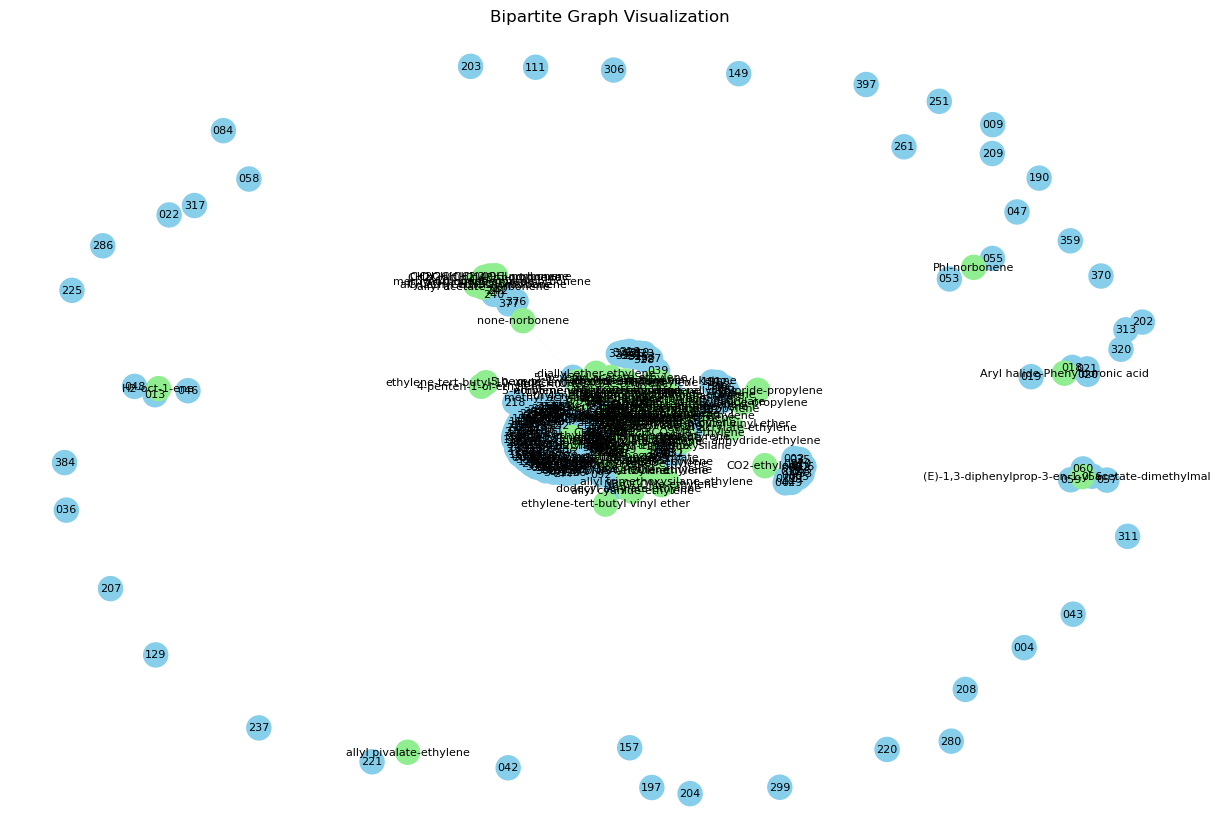

In [143]:
## Apply crossfold to create 5 training graphs
# Define 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)


edge_list = list(exp_bipartite.edges()) 

# Split the edges into 5 folds
folds = list(kf.split(edge_list))

# Create 5-fold cross-validation sets
cv_sets = []
for train_index, test_index in folds:
    train_edges = [edge_list[i] for i in train_index]
    test_edges = [edge_list[i] for i in test_index]
    cv_sets.append((train_edges, test_edges))

# Create a list to store the new graphs
bipartite_train_list = []
test_set_list = []
# Create a dictionary to store the test-edges for each graph 
dict_test_edges = {}

# Verify the cross-validation sets
for i, (train_edges, test_edges) in enumerate(cv_sets):
    print(f"Fold {i+1}:")
    print(f"  Training set size: {len(train_edges)}")
    print(f"  Test set size: {len(test_edges)}")
    print(f"  Test set : {test_edges}")
    dict_test_edges[f'test_edge_{i}'] = test_edges
    test_set_list.append(test_edges)

# Create new graphs for cross validation by removing test edges for each fold
for i, (train_edges, test_edges) in enumerate(cv_sets):
    bipartite_train = exp_bipartite.copy()
    bipartite_train.remove_edges_from(test_edges)
    bipartite_train_list.append(bipartite_train)

    # Print the sizes of the training and test sets
    print(f"Fold {i+1}:")
    print(f"  Training set size: {len(train_edges)}")
    print(f"  Test set size: {len(test_edges)}")

# Verify the new graphs
for i, bipartite_train in enumerate(bipartite_train_list):
    print(f"bipartite_train_{i+1} number of edges: {len(bipartite_train.edges())}")

#Visualize one of the training set graphs
visualize_bipartite_graph(bipartite_train_list[0], d_nodes, t_nodes)

# check_test_set(203, 'ethylene-none',dict_test_edges['test_edge_0'])

# Dictionary to store DataFrames for each graph in each cross validation fold
df_dict_dt = {}
df_dict_cluster_dt = {}
df_dict_merged_dt ={}

In [144]:
# Determine number of existing edges, missing edges
num_existing_edges = exp_bipartite.number_of_edges()
num_possible_edges = num_d_nodes*num_t_nodes
# Number of missing edges
num_missing_edges = num_possible_edges - num_existing_edges

In [146]:

# Identify which cluster dictionary is used to create ligand clusters
clusters = updated_cluster_dict_all_descriptor 
# Iterate each graph within training set

# two list: one for bipartite graph_train, one for test_set list
for idx, (G,test_edges) in enumerate(zip(bipartite_train_list,test_set_list)):
# for G in B_train_list:
    # Get the pairs that have edges in training set graph
    edges_set = set(G.edges())

    print("Number of edges in this graph for training set: ", len(edges_set))
    # print("Number of all possible edges in this graph for training set: ", len(set(possible_edges)))
    # Find pairs with no edges between them
    training_no_edge_pairs = set(possible_edges) - edges_set
    training_no_edge_pairs = list(training_no_edge_pairs)

    # Ensure that the missing edges in each training set is equal to the sum of both the number of missing edges in the original graph and the additional ones from the test set
    assert len(training_no_edge_pairs) == num_missing_edges + len(test_edges)
    
    data = []
    # Calculate link prediction measures (CN, JC, PA) between for each pair of nodes without edges
    for d_node, t_node in training_no_edge_pairs:
        # print('d_node: ', d_node, ' t_node: ', t_node)
        num_common_neighbor, jaccard_coefficient = common_neighbor_jaccard_coef(G, d_node, t_node)
        preferential_d_t = preferential_attachment(G, d_node,t_node)
        data.append({
            'd_node': d_node,
            't_node': t_node,
            'num_common_neighbor': num_common_neighbor,
            'jaccard_coefficient': jaccard_coefficient,
            'preferential_attach' : preferential_d_t
        })
    
    # Create the DataFrame of link prediction algorithm containing each d t pair that has missing edges, store into dctionary of dataframes
    df_neighbor = pd.DataFrame(data)
    df_dict_dt[f'graph_{idx}'] = df_neighbor
    print('Number of rows in node dataframe: ', df_dict_dt[f'graph_{idx}'].shape[0])

    # Create a new graph connecting t_nodes to clusters to form ligand cluster - reaction class links
    H = nx.Graph()
    H_zero = nx.Graph() #Add a H_zero graph to store data for links where weight = 0 
    # Add t nodes to the new graph
    H.add_nodes_from(t_nodes, bipartite=1)
    H_zero.add_nodes_from(t_nodes, bipartite=1)
    # Add cluster nodes to the new graph
    H.add_nodes_from(clusters.keys(), bipartite=0)
    H_zero.add_nodes_from(clusters.keys(), bipartite=0)

    print('Number of clusters: ', len(clusters))
    # Calculate the weights for links between clusters and t_nodes
    # Initialize a dictionary to store weights for cluster-t_node links
    cluster_t_weights = {cluster: {t: 0 for t in t_nodes} for cluster in clusters}
    
    # Create list for links with zero weight
    cluster_t_zero_weights = {cluster: {t: 0 for t in t_nodes} for cluster in clusters}    
    
    # Iterate over the original edges and update the weights for the new graph
    for d, t in G.edges():
        for cluster, d_list in clusters.items():  #extract cluster name and ligand node list within cluster
            if d in d_list:      
                cluster_t_weights[cluster][t] += 1
    # Add weighted edges to the new graph
    edge_added_count = 0
    for cluster, t_weights in cluster_t_weights.items():
        for t, w in t_weights.items():
            if w > 0:  # Only add edges with non-zero weight
                H.add_edge(cluster, t, weight=w)    #Missing some t, cluster combinations since there is no link.
                edge_added_count = edge_added_count + 1
            elif w == 0:
                H_zero.add_edge(cluster, t, weight=w)
                edge_added_count = edge_added_count + 1

    print('Edge added Count: ', edge_added_count)
    # Print the new graph edges with weights
    print("Edges in the new graph with weights:")
    
    for (u, v, wt) in H.edges(data='weight'):
        print(f"({u}, {v}, {wt})")
        
    cluster_edge_weights_list = list(H.edges(data='weight'))  # list of weights for c-t edges
    cluster_edge_zero_weights_list = list(H_zero.edges(data='weight')) # list of missing links for c-t combinations

    #Make sure number of cluster x number of t nodes equal to the number of all possible edges between cluster and t nodes
    assert len(clusters) * num_t_nodes == len(cluster_edge_weights_list) + len(cluster_edge_zero_weights_list)
    
    print(len(cluster_edge_weights_list)) #180 of c - t connection with weight > 0
    print(len(cluster_edge_zero_weights_list)) #210 of c - t connection with weight = 0
    
    # Create a list to store the data
    data_cluster = []

    count = 0
    # Iterate through the clusters and their connections to t_nodes, caluclate link prediction measures 
    for t, c, weight in cluster_edge_weights_list:
        for d in clusters[c]:
            count = count + 1
            degree_d_cluster = H.degree(c)
            degree_t = H.degree(t)
            data_cluster.append((d, 
                                 t, 
                                 weight, 
                                 len(cluster),
                                 weight/len(cluster), #Jaccard coefficient
                                 degree_d_cluster,
                                 degree_t,
                                 degree_d_cluster*degree_t))   #Preferential attachment
    print("Count: ", count)
    # Add the t_node cluster pair with no weights in to the dataframe as well, so we can get all 105 combinations of d and t
    for t, c, weight in cluster_edge_zero_weights_list:
        for d in clusters[c]:
            count = count + 1
            degree_d_cluster = H.degree(c)
            degree_t = H.degree(t)
            data_cluster.append((d, 
                                 t, 
                                 weight, 
                                 len(cluster),
                                 weight/len(cluster),
                                 degree_d_cluster,
                                 degree_t,
                                 degree_d_cluster*degree_t))
    print("Count2: ", count)
    # If t, cluster has no link, then we still need to record the d and t involved, where weight = 0, number of d in cluster is based on c
    # degree of cluster is equal to cluster, # jaccard coefficient is 0, degree_t is based on t preferential_attachment is calculated properly
    
    # Create the dataframe for cluster-t 
    cluster_df = pd.DataFrame(data_cluster, columns=['d_node', 
                                                     't_node', 
                                                     'common_neighbor_tc',
                                                     'number of d in cluster',
                                                     'jaccard_coeff_tc',
                                                     'degree_d_cluster',
                                                     'degree_t',
                                                     'preferential_attachment_cluster'])
    
    print('Number of rows in cluster dataframe: ', cluster_df.shape[0])  #should have 105?

    # Make sure that the number of rows for the cluster dataframe is equal to the total possible combinations of all node connections
    assert cluster_df.shape[0] == len(set(possible_edges)), f"Assertion failed: cluster_df.shape[0] = {cluster_df.shape[0]}, len(set(possible_edges)) = {len(set(possible_edges))}"

    # Create a DataFrame from training_no_edge_pairs
    training_no_edge_pairs_df = pd.DataFrame(training_no_edge_pairs, columns=['d_node', 't_node'])
    print('Number of rows in no edge pair dataframe: ', training_no_edge_pairs_df.shape[0])
    
    # Merge the cluster_df with training_no_edge_pairs_df on d_node and t_node
    filtered_cluster_df = pd.merge(cluster_df, training_no_edge_pairs_df, on=['d_node', 't_node'])
    
    # Store dataframe into a dictionary of dataframes
    df_dict_cluster_dt[f'graph_{idx}'] = filtered_cluster_df

    df_dict_merged_dt[f'graph_{idx}'] = pd.merge(df_dict_dt[f'graph_{idx}'], df_dict_cluster_dt[f'graph_{idx}'], on=['d_node', 't_node'], how='inner')
    # print('Number of rows in merged dataframe: ', df_dict_merged_dt[f'graph_{idx}'].shape[0])

    # Make sure that the number of rows after merging is equal to the number of missing pairs from the training graph 
    assert df_dict_merged_dt[f'graph_{idx}'].shape[0] == len(training_no_edge_pairs)

# Check graph_0 within both dictionary
# print('Dataframe_neighbors: ',df_dict_dt['graph_0'])
# print('Dataframe_clusters: ',df_dict_cluster_dt['graph_0'])  
# print('Merged dataframe: ',df_dict_merged_dt['graph_0']) 
column_list = df_dict_merged_dt['graph_0'].columns.tolist() 
print(column_list)

Number of edges in this graph for training set:  630
Number of rows in node dataframe:  27629
Number of clusters:  5
Edge added Count:  385
Edges in the new graph with weights:
(CO2-ethylene, c1, 1)
(CO2-ethylene, c2, 1)
(CO2-ethylene, c3, 7)
(CO2-ethylene, c4, 1)
(CO2-ethylene, c5, 8)
(Aryl halide-Phenylboronic acid, c5, 4)
(H2-oct-1-ene, c3, 1)
(H2-oct-1-ene, c5, 2)
(PhI-norbonene, c2, 1)
(PhI-norbonene, c5, 1)
((E)-1,3-diphenylprop-3-en-1-yl acetate-dimethylmalonate, c2, 2)
((E)-1,3-diphenylprop-3-en-1-yl acetate-dimethylmalonate, c4, 1)
((E)-1,3-diphenylprop-3-en-1-yl acetate-dimethylmalonate, c5, 1)
(ethylene-none, c1, 72)
(ethylene-none, c2, 62)
(ethylene-none, c3, 38)
(ethylene-none, c4, 27)
(ethylene-none, c5, 44)
(ethylene-methyl acrylate, c1, 5)
(ethylene-methyl acrylate, c2, 32)
(ethylene-methyl acrylate, c3, 18)
(ethylene-methyl acrylate, c4, 7)
(ethylene-methyl acrylate, c5, 12)
(butyl acrylate-ethylene, c1, 1)
(butyl acrylate-ethylene, c2, 2)
(butyl acrylate-ethylene, c3,

In [147]:
# Evaluate Precision & AUPR for each cross validation by using the test set established earlier:
# Iterate through each dataframe. For each dataframe, obtain rows with test set node pairs only (which should all be 1) normalize prediction scores, 
# Generate Precision & AUPR for that dataframe for each link prediction algorithm
# Then obtain average AUC and AUPR for all dataframe to reach link prediction algorithm 
# References for understanding link prediction evaluation metrics:
# Simone Daminelli et al 2015 New J. Phys. 17 113037 Main journal used for adopting precision & aupr over auc
# Yang, Y., Lichtenwalter, R.N. & Chawla, N.V. Evaluating link prediction methods. Knowl Inf Syst 45, 751–782 (2015). States that ROC is deceptive.
    
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score #Not accurage for checking area under AUC. https://datascience.stackexchange.com/questions/52130/about-sklearn-metrics-average-precision-score-documentation
from sklearn.metrics import precision_recall_curve, auc

score_column = ['num_common_neighbor', 
                'jaccard_coefficient', 
                'preferential_attach', 
                'common_neighbor_tc', 
                'jaccard_coeff_tc', 
                'preferential_attachment_cluster']

# Initialize DataFrames to store AUC and AUPR scores
auc_df = pd.DataFrame(index=score_column)
aupr_df = pd.DataFrame(index=score_column)
all_results = []
for idx in range(5):
    df_merge = df_dict_merged_dt[f'graph_{idx}'] # Get all missing edges from the training set graph
    # Normalize each column
    for column in score_column:
        min_value = df_merge[column].min()
        max_value = df_merge[column].max()
        df_merge[column] = (df_merge[column] - min_value) / (max_value - min_value)

    #print('df_merge_normalized: ', df_merge)
    test_edges_set = set(dict_test_edges[f'test_edge_{idx}']) # Used to identify the test_edges

    l = len(test_edges_set)
    
    print('List of test edges:', test_edges_set)
    # Create a new column in df_merge called 'actual outcome'
    # For d node and t nodes that are within the list_test_edges, put 1 in the acutal outcome
    # For the rest of the nodes, put 0
    df_merge['actual outcome'] = df_merge.apply(lambda row: 1 if (row['d_node'], row['t_node']) in test_edges_set else 0, axis=1)
    print(df_merge)


    # Iterate through each prediction algorithm and calculate the metrics
    results = []
    for score_type in score_column:
        precision_at_L, aupr = calculate_metric(df_merge, score_type, l)
        results.append({'Score_type': score_type, 'precision_at_L': precision_at_L, 'aupr': aupr})
        
    # Convert the results to a DataFrame
    results_df = pd.DataFrame(results)

    # Append to all results
    all_results.append(results_df)
    
    # Display the results
    print(results_df)


# Concatenate all results DataFrames into a single DataFrame
concatenated_results = pd.concat(all_results)

# Group by algorithm and calculate the mean of precision_at_L and aupr
average_results = concatenated_results.groupby('Score_type').mean().reset_index()
    # Iterate through each prediction algorithm, by creating a dataframe where we have the d_node, t_node, prediction algorithm, and actual outcome
    # sort rows based on the normalized score under the prediction algorithm
    # Obtain precision value by analyzing how many 1s are there in the top L rows out of L rows
    # Obtain AUPR with both column
# Display the average results
print('Average results: ', average_results)


List of test edges: {('041', 'CH2CH(CH2)9OH-ethylene'), ('285', 'acrylic acid-ethylene'), ('403', 'ethylene-norbonene'), ('344', 'ethylene-none'), ('280', 'ethylene-none'), ('038', 'CH2CH(CH2)9OH-ethylene'), ('315', 'ethylene-styrene'), ('240', 'CH2CH(CH2)9Cl-norbonene'), ('187', 'none-propylene'), ('260', 'none-propylene'), ('348', 'ethylene-methyl acrylate'), ('281', 'acrylonitrile-ethylene'), ('253', 'allyl acetate-ethylene'), ('361', 'ethylene-none'), ('401', 'ethylene-methyl acrylate'), ('356', 'ethylene-methyl acrylate'), ('038', 'ethylene-vinyl chloride'), ('137', 'ethylene-methyl acrylate'), ('080', 'ethylene-none'), ('339', 'ethylene-none'), ('086', 'ethylene-none'), ('041', 'CH2CH(CH2)4Cl-ethylene'), ('308', 'FOA-ethylene'), ('407', 'acrylic acid-ethylene'), ('282', 'ethylene-methyl acrylate'), ('402', 'ethylene-methyl acrylate'), ('038', 'ethylene-methyl acrylate'), ('100', 'acrylonitrile-ethylene'), ('145', 'CH2CH(CH2)4Cl-ethylene'), ('257', 'allyl chloride-ethylene'), ('20

In [148]:
average_results

Score_type  precision_at_L      aupr
0               common_neighbor_tc        0.355406  0.286345
1                 jaccard_coeff_tc        0.355406  0.286345
2              jaccard_coefficient        0.002532  0.056498
3              num_common_neighbor        0.168774  0.126393
4              preferential_attach        0.220850  0.122714
5  preferential_attachment_cluster        0.034266  0.087509

## Make function to choose a candidate, and then score different reaction classes from the ligand



## Make function to chose a reaction class, and then rank different ligand for that reaction class

In [149]:
# Obtain predictions for the origial network

# Identify which cluster dictionary is used to create ligand clusters
clusters = updated_cluster_dict_all_descriptor 

edges_set = set(G.edges())


In [150]:
# Identify which cluster dictionary is used to create ligand clusters
clusters = updated_cluster_dict_all_descriptor 

edge_set = set(exp_bipartite.edges()) 

num_no_edge_pairs = list(set(possible_edges) - edges_set)

for d_node, t_node in num_no_edge_pairs:
    # print('d_node: ', d_node, ' t_node: ', t_node)
    num_common_neighbor, jaccard_coefficient = common_neighbor_jaccard_coef(exp_bipartite, d_node, t_node)
    preferential_d_t = preferential_attachment(exp_bipartite, d_node,t_node)
    data.append({
        'd_node': d_node,
        't_node': t_node,
        'num_common_neighbor': num_common_neighbor,
        'jaccard_coefficient': jaccard_coefficient,
        'preferential_attach' : preferential_d_t
    })

# Create the DataFrame of link prediction algorithm containing each d t pair that has missing edges, store into dctionary of dataframes
df_all_neighbor = pd.DataFrame(data)
df_all_neighbor = df_all_neighbor.drop_duplicates(subset=['d_node', 't_node'])


# Create a new graph connecting t_nodes to clusters to form ligand cluster - reaction class links
H = nx.Graph()
H_zero = nx.Graph() #Add a H_zero graph to store data for links where weight = 0 
# Add t nodes to the new graph
H.add_nodes_from(t_nodes, bipartite=1)
H_zero.add_nodes_from(t_nodes, bipartite=1)
# Add cluster nodes to the new graph
H.add_nodes_from(clusters.keys(), bipartite=0)
H_zero.add_nodes_from(clusters.keys(), bipartite=0)

print('Number of clusters: ', len(clusters))
# Calculate the weights for links between clusters and t_nodes
# Initialize a dictionary to store weights for cluster-t_node links
cluster_t_weights = {cluster: {t: 0 for t in t_nodes} for cluster in clusters}

# Create list for links with zero weight
cluster_t_zero_weights = {cluster: {t: 0 for t in t_nodes} for cluster in clusters}    

# Iterate over the original edges and update the weights for the new graph
for d, t in exp_bipartite.edges():
    for cluster, d_list in clusters.items():  #extract cluster name and ligand node list within cluster
        if d in d_list:      
            cluster_t_weights[cluster][t] += 1
# Add weighted edges to the new graph
edge_added_count = 0
for cluster, t_weights in cluster_t_weights.items():
    for t, w in t_weights.items():
        if w > 0:  # Only add edges with non-zero weight
            H.add_edge(cluster, t, weight=w)    #Missing some t, cluster combinations since there is no link.
            edge_added_count = edge_added_count + 1
        elif w == 0:
            H_zero.add_edge(cluster, t, weight=w)
            edge_added_count = edge_added_count + 1

print('Edge added Count: ', edge_added_count)
# Print the new graph edges with weights
print("Edges in the new graph with weights:")

for (u, v, wt) in H.edges(data='weight'):
    print(f"({u}, {v}, {wt})")
    
cluster_edge_weights_list = list(H.edges(data='weight'))  # list of weights for c-t edges
cluster_edge_zero_weights_list = list(H_zero.edges(data='weight')) # list of missing links for c-t combinations

#Make sure number of cluster x number of t nodes equal to the number of all possible edges between cluster and t nodes
assert len(clusters) * num_t_nodes == len(cluster_edge_weights_list) + len(cluster_edge_zero_weights_list)

print('Number of t nodes:', num_t_nodes)
print('Number of d nodes:', num_d_nodes)

# Create a list to store the data
data_cluster = []

count = 0
# Iterate through the clusters and their connections to t_nodes, caluclate link prediction measures 
for t, c, weight in cluster_edge_weights_list:
    for d in clusters[c]:
        count = count + 1
        degree_d_cluster = H.degree(c)
        degree_t = H.degree(t)
        data_cluster.append((d, 
                             t, 
                             weight, 
                             len(cluster),
                             weight/len(cluster), #Jaccard coefficient
                             degree_d_cluster,
                             degree_t,
                             degree_d_cluster*degree_t))   #Preferential attachment
print("Count: ", count)
# Add the t_node cluster pair with no weights in to the dataframe as well, so we can get all 105 combinations of d and t
for t, c, weight in cluster_edge_zero_weights_list:
    for d in clusters[c]:
        count = count + 1
        degree_d_cluster = H.degree(c)
        degree_t = H.degree(t)
        data_cluster.append((d, 
                             t, 
                             weight, 
                             len(cluster),
                             weight/len(cluster),
                             degree_d_cluster,
                             degree_t,
                             degree_d_cluster*degree_t))
print("Count2: ", count)
# If t, cluster has no link, then we still need to record the d and t involved, where weight = 0, number of d in cluster is based on c
# degree of cluster is equal to cluster, # jaccard coefficient is 0, degree_t is based on t preferential_attachment is calculated properly

# Create the dataframe for cluster-t 
cluster_df = pd.DataFrame(data_cluster, columns=['d_node', 
                                                 't_node', 
                                                 'common_neighbor_tc',
                                                 'number of d in cluster',
                                                 'jaccard_coeff_tc',
                                                 'degree_d_cluster',
                                                 'degree_t',
                                                 'preferential_attachment_cluster'])

print('Number of rows in cluster dataframe: ', cluster_df.shape[0])  

# Make sure that the number of rows for the cluster dataframe is equal to the total possible combinations of all node connections
assert cluster_df.shape[0] == len(set(possible_edges)), f"Assertion failed: cluster_df.shape[0] = {cluster_df.shape[0]}, len(set(possible_edges)) = {len(set(possible_edges))}"

Number of clusters:  5
Edge added Count:  385
Edges in the new graph with weights:
(CO2-ethylene, c1, 1)
(CO2-ethylene, c2, 1)
(CO2-ethylene, c3, 9)
(CO2-ethylene, c4, 2)
(CO2-ethylene, c5, 9)
(Aryl halide-Phenylboronic acid, c2, 1)
(Aryl halide-Phenylboronic acid, c5, 4)
(H2-oct-1-ene, c2, 1)
(H2-oct-1-ene, c3, 1)
(H2-oct-1-ene, c5, 4)
(PhI-norbonene, c2, 1)
(PhI-norbonene, c5, 1)
((E)-1,3-diphenylprop-3-en-1-yl acetate-dimethylmalonate, c2, 3)
((E)-1,3-diphenylprop-3-en-1-yl acetate-dimethylmalonate, c4, 1)
((E)-1,3-diphenylprop-3-en-1-yl acetate-dimethylmalonate, c5, 1)
(ethylene-none, c1, 86)
(ethylene-none, c2, 75)
(ethylene-none, c3, 45)
(ethylene-none, c4, 33)
(ethylene-none, c5, 47)
(ethylene-methyl acrylate, c1, 11)
(ethylene-methyl acrylate, c2, 43)
(ethylene-methyl acrylate, c3, 23)
(ethylene-methyl acrylate, c4, 10)
(ethylene-methyl acrylate, c5, 15)
(butyl acrylate-ethylene, c1, 1)
(butyl acrylate-ethylene, c2, 2)
(butyl acrylate-ethylene, c3, 6)
(butyl acrylate-ethylene, 

In [151]:
df_all_neighbor 

d_node                                           t_node  \
0        377                          CH2CH(CH2)4OAc-ethylene   
1        244                         CH2CH(CH2)8COOH-ethylene   
2        164                           allyl acetate-ethylene   
3        283                                     6FA-ethylene   
4        222                          CH2CH(CH2)4Br-norbonene   
...      ...                                              ...   
27623    056  5-norbonene-2,3-dicarboxylic anhydride-ethylene   
27624    395                            2-vinylfuran-ethylene   
27625    201                       5-hexenyl acetate-ethylene   
27626    171                     ethylene-tert-butyl acrylate   
27627    095                       5-hexenyl acetate-ethylene   

       num_common_neighbor  jaccard_coefficient  preferential_attach  
0                        0             0.000000                    1  
1                        7             0.875000                   12  
2                       16             0.727273                   40  
3                        3             0.750000                    3  
4                        0             0.000000                    3  
...                    ...                  ...                  ...  
27623                    0             0.000000                    1  
27624                    4             0.571429                    6  
27625                    3             1.000000                    2  
27626                    0             0.000000                    0  
27627                    0             0.000000                    2  

[27628 rows x 5 columns]

In [152]:
# Merge the two dataframes on d_node and t_node to obtain all link prediction measures for missing links in the experimental bipartite network
merged_df = pd.merge(df_all_neighbor, cluster_df, on=['d_node', 't_node'])

# Display the merged dataframe
merged_df

d_node                                           t_node  \
0        377                          CH2CH(CH2)4OAc-ethylene   
1        244                         CH2CH(CH2)8COOH-ethylene   
2        164                           allyl acetate-ethylene   
3        283                                     6FA-ethylene   
4        222                          CH2CH(CH2)4Br-norbonene   
...      ...                                              ...   
27623    056  5-norbonene-2,3-dicarboxylic anhydride-ethylene   
27624    395                            2-vinylfuran-ethylene   
27625    201                       5-hexenyl acetate-ethylene   
27626    171                     ethylene-tert-butyl acrylate   
27627    095                       5-hexenyl acetate-ethylene   

       num_common_neighbor  jaccard_coefficient  preferential_attach  \
0                        0             0.000000                    1   
1                        7             0.875000                   12   
2                       16             0.727273                   40   
3                        3             0.750000                    3   
4                        0             0.000000                    3   
...                    ...                  ...                  ...   
27623                    0             0.000000                    1   
27624                    4             0.571429                    6   
27625                    3             1.000000                    2   
27626                    0             0.000000                    0   
27627                    0             0.000000                    2   

       common_neighbor_tc  number of d in cluster  jaccard_coeff_tc  \
0                       0                       2               0.0   
1                       2                       2               1.0   
2                       5                       2               2.5   
3                       1                       2               0.5   
4                       2                       2               1.0   
...                   ...                     ...               ...   
27623                   1                       2               0.5   
27624                   1                       2               0.5   
27625                   0                       2               0.0   
27626                   1                       2               0.5   
27627                   0                       2               0.0   

       degree_d_cluster  degree_t  preferential_attachment_cluster  
0                    41         1                               41  
1                    41         4                              164  
2                    41         5                              205  
3                    37         3                              111  
4                    52         2                              104  
...                 ...       ...                              ...  
27623                41         1                               41  
27624                41         5                              205  
27625                52         1                               52  
27626                52         5                              260  
27627                48         1                               48  

[27628 rows x 11 columns]

In [198]:
# Define the function
def get_top_10_t_nodes(df, d_node, measure):
    # Filter the DataFrame for the specified d_node
    filtered_df = df[df['d_node'] == d_node]
    
    # Sort the DataFrame by the specified measure in descending order
    sorted_df = filtered_df.sort_values(by=measure, ascending=False)
    
    # Select the top 10 t_nodes
    top_10_t_nodes = sorted_df.head(10)[['t_node', measure]]
    result = list(top_10_t_nodes.itertuples(index=False, name=None))
    
    return result

# Define the function
def get_top_10_d_nodes(df, t_node, measure):
    # Filter the DataFrame for the specified t_node
    filtered_df = df[df['t_node'] == t_node]
    
    # Sort the DataFrame by the specified measure in descending order
    sorted_df = filtered_df.sort_values(by=measure, ascending=False)
    
    # Select the top 10 d_nodes
    top_10_d_nodes = sorted_df.head(10)[['d_node', measure]]
    result = list(top_10_d_nodes.itertuples(index=False, name=None))
    
    return result



# Example usage
d_node = '259'
measure = 'common_neighbor_tc'
top_10_t_nodes = get_top_10_t_nodes(merged_df, d_node, measure)
print("Top 10 t_nodes for d_node {} based on {}:".format(d_node, measure))
print(top_10_t_nodes)

# Example usage
t_node = 'CO2-ethylene'
measure = 'common_neighbor_tc'
top_10_d_nodes = get_top_10_d_nodes(merged_df, t_node, measure)
print("Top 10 t_nodes for t_node {} based on {}:".format(t_node, measure))
print(top_10_d_nodes)



Top 10 t_nodes for d_node 259 based on common_neighbor_tc:
[('ethylene-none', 86), ('ethylene-methyl acrylate', 11), ('none-propylene', 7), ('ethylene-methyl 10-undecenoate', 7), ('allyl acetate-ethylene', 6), ('CH2CH(CH2)9OH-ethylene', 3), ('ethylene-norbonene', 3), ('butyl vinyl ether-ethylene', 3), ('allyl chloride-ethylene', 3), ('ethylene-vinyl chloride', 2)]
Top 10 t_nodes for t_node CO2-ethylene based on common_neighbor_tc:
[('055', 9), ('247', 9), ('390', 9), ('386', 9), ('263', 9), ('318', 9), ('142', 9), ('409', 9), ('033', 9), ('003', 9)]


In [154]:
# 55, 315, 390, 386, 263, 318, 291
# Stuff to fix: why is it recommending nodes that already have link with CO2-ethylene? SOmething is going wrong. 

In [155]:
exp_bipartite

In [171]:
import networkx as nx

def get_neighbors_of_degree(graph, node, max_degree):
    """
    Get the neighbors of a given node up to a specified degree and the count of nodes at each degree.
    
    Parameters:
    - graph: networkx.Graph
    - node: the node to examine
    - max_degree: the maximum degree up to which neighbors should be returned
    
    Returns:
    - neighbors_by_degree: a dictionary where keys are degrees and values are sets of nodes
    - counts_by_degree: a dictionary where keys are degrees and values are the counts of nodes
    """
    if node not in graph:
        raise ValueError("Node not found in the graph")
    
    neighbors_by_degree = {0: {node}}
    counts_by_degree = {0: 1}
    current_level = {node}
    
    for degree in range(1, max_degree + 1):
        next_level = set()
        for n in current_level:
            next_level.update(graph.neighbors(n))
        next_level -= neighbors_by_degree[degree - 1]  # Remove already seen nodes
        neighbors_by_degree[degree] = next_level
        counts_by_degree[degree] = len(next_level)
        current_level = next_level
    
    return neighbors_by_degree, counts_by_degree

# Example usage:
B = nx.Graph()
# Add edges (assume it's a bipartite graph)
B.add_edges_from([('A', 1), ('A', 2), ('B', 2), ('C', 3), ('C', 4), ('D', 4)])

node = 'A'
max_degree = 2
neighbors_by_degree, counts_by_degree = get_neighbors_of_degree(B, node, max_degree)
print(f"Neighbors of node '{node}' up to degree {max_degree}: {neighbors_by_degree}")
print(f"Counts of nodes by degree: {counts_by_degree}")


Neighbors of node 'A' up to degree 2: {0: {'A'}, 1: {1, 2}, 2: {'B', 'A'}}
Counts of nodes by degree: {0: 1, 1: 2, 2: 2}


In [195]:
# Use function for exp_bipartite graph


node = '317'
max_degree = 3
neighbors_by_degree, counts_by_degree = get_neighbors_of_degree(exp_bipartite, node, max_degree)
print(f"Neighbors of node '{node}' up to degree {max_degree}: {neighbors_by_degree}")
print(f"Counts of nodes by degree: {counts_by_degree}")

Neighbors of node '317' up to degree 3: {0: {'317'}, 1: {'ethylene-norbonene'}, 2: {'327', '323', '402', '400', '403', '307', '153', '038', '322', '305', '321', '198', '186', '319', '328', '317', '187', '401', '318', '326', '196', '325', '320', '324', '308', '309', '329'}, 3: {'6FA-ethylene', '1-hexene-ethylene', 'ethylene-methyl acrylate', 'N-isopropylacrylamide-ethylene', 'acrylonitrile-ethylene', '2-vinylfuran-ethylene', '5-hexenyl acetate-ethylene', 'ethylene-ethylene glycol monoacrylate', 'ethylene-methyl vinyl ketone', '5-norbonene-2,3-dicarboxylic anhydride-ethylene', 'ethylene-styrene', 'ethylene-vinyl acetate', 'ethylene-norbonene', 'none-propylene', 'butyl vinyl ether-ethylene', 'acrylic acid-ethylene', 'allyl acetate-ethylene', 'ethylene-none', 'ethyl vinyl ether-ethylene', 'FOA-ethylene', 'butyl acrylate-ethylene', 'CH2CH(CH2)9OH-ethylene', 'CH2CH(CH2)8COOH-ethylene', '5-norbornene-2-yl acetate-ethylene', 'ethylene-tert-butyl acrylate', 'ethylene-vinyl chloride', 'NB-COOH-e

In [196]:
def draw_graph_with_highlight(graph, neighbors_by_degree, degree):
    pos = nx.circular_layout(graph)
    plt.figure(figsize=(8, 8))
    
    # Draw the base graph
    nx.draw(graph, pos, with_labels=False, node_color='lightgrey', node_size=50, edge_color='grey', width=0.5)
    
    # Highlight the nodes up to the specified degree
    for d in range(degree + 1):
        nodes = neighbors_by_degree[d]
        nx.draw_networkx_nodes(graph, pos, nodelist=nodes, node_color=f"C{d}", node_size=70, label=f"Degree {d}")
    
    plt.legend()
    plt.title(f"Nodes up to degree {degree}")
    plt.show()


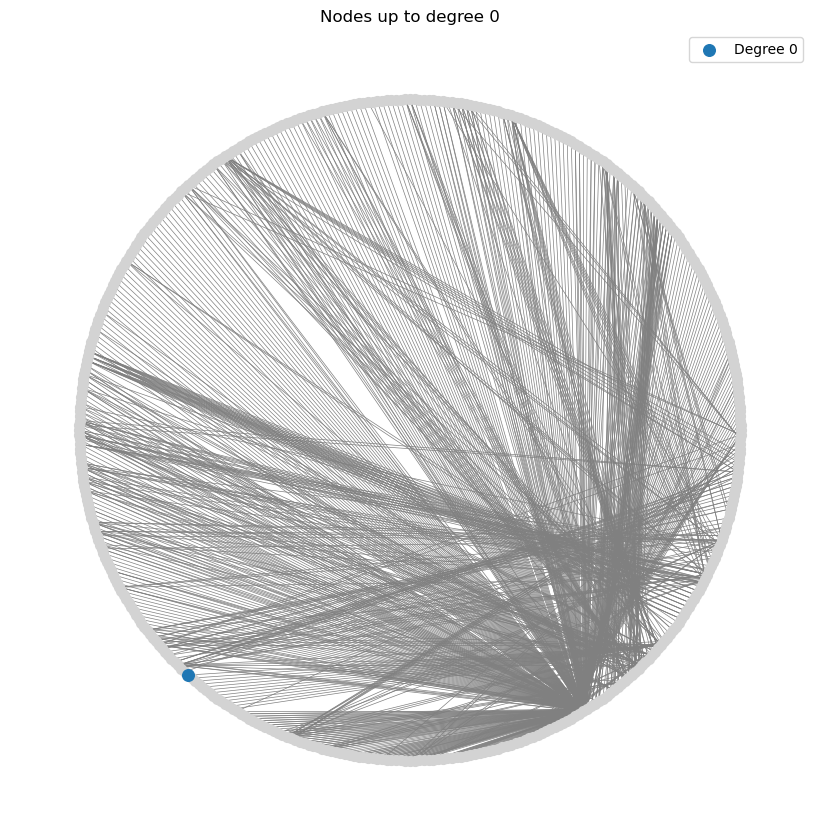

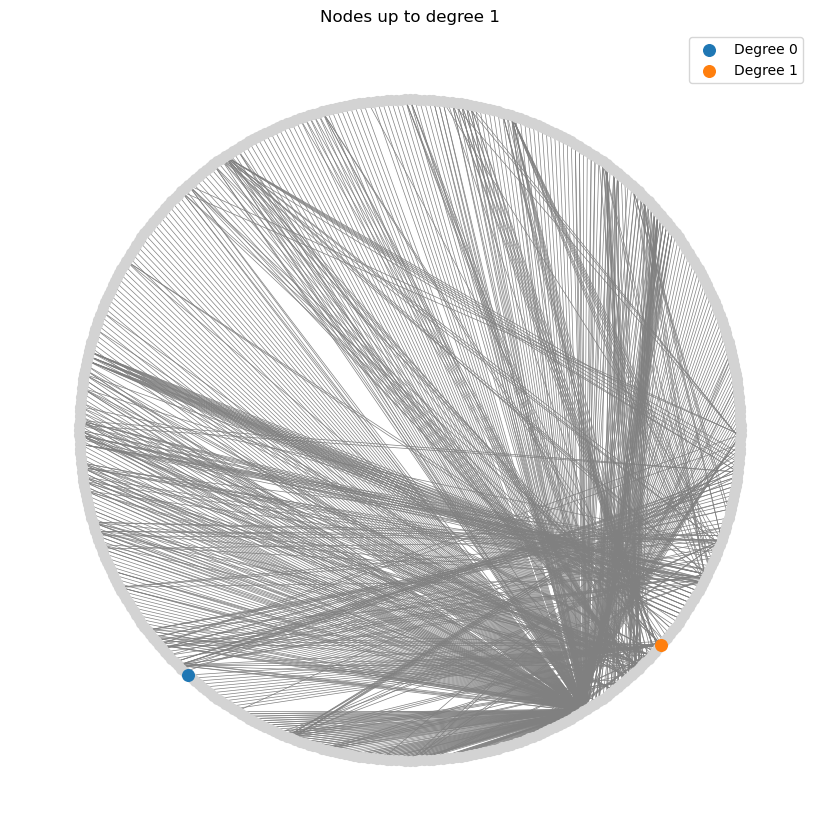

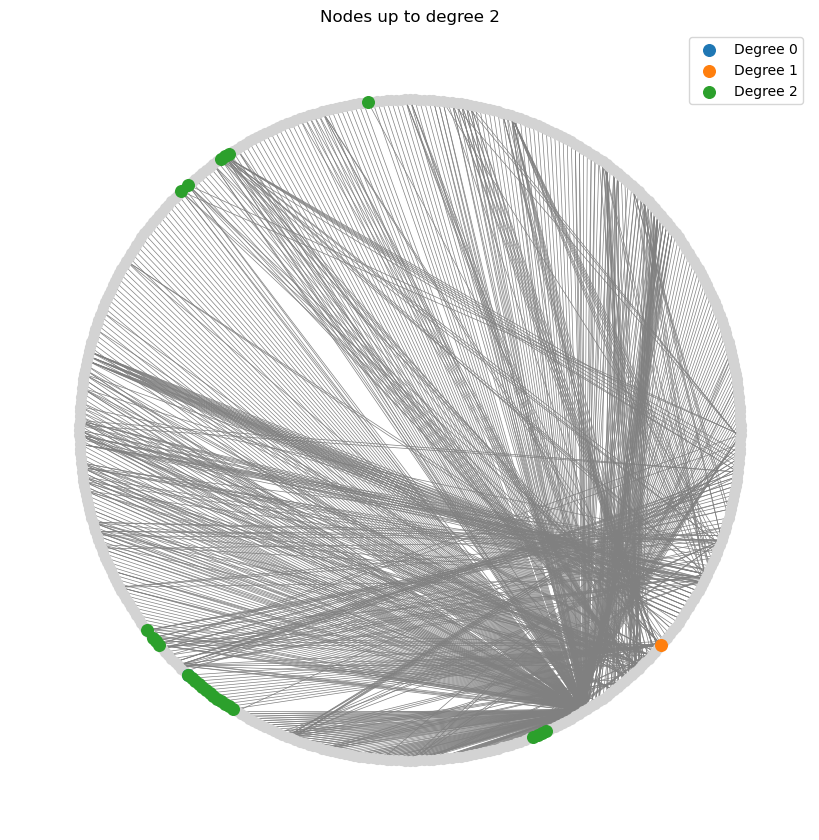

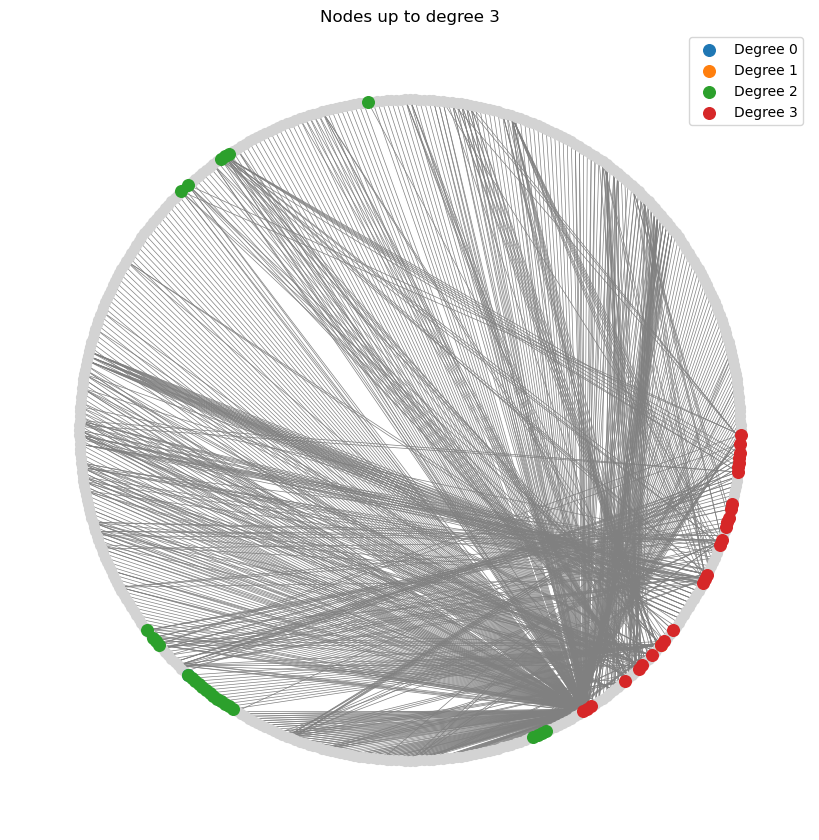

In [197]:
for d in range(max_degree + 1):
    draw_graph_with_highlight(exp_bipartite, neighbors_by_degree, d)